In [220]:
import multiprocess
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas
from CapstoneOverlap import *
from importlib import reload
reload(CapstoneOverlap)

DIR_DATA = 'Data/'

First we can check what functions have been defined in CapstoneOverlap.py

Note: for details refer to the file, or
* For documentation:
    * help(modname.funcname)
    * ?modname.funcname or modname.funcname?
    * %pinfo modname.funcname
* For source code:
    * ??modname.funcname or modname.funcname??
    * %pinfo2 modname.funcname
    * import inspect; print(inspect.getsource(modname.funcname))

In [221]:
CapstoneOverlap.__all__

['countCoordinates',
 'maxSubCoordinates',
 'cleanGeometry',
 'katana',
 'katanaByParts',
 'intersectionBySjoin',
 'intersectGDF',
 'intersectGDFMP',
 'convertToOldResults',
 'loadResults_',
 'loadResults',
 'saveResults_',
 'saveResults',
 'loadComputeSave']

In [2]:
def GMLtoGDF(filename):
    gdf = geopandas.read_file(filename)
    gdf = gdf.set_crs(epsg=3347) # Needed only for FSA file, the others are 3347 and parsed correctly by geopandas, and the pdf in the zip file has the same projection parameters (FSA vs. DA, ADA, CT)
    gdf['Area'] = gdf.geometry.to_crs(epsg=6931).area # Equal-area projection # MODIFY THIS to account for validity regions of each geometry
    gdf['Centroid'] = gdf.geometry.centroid
    gdf['Centroid'] = gdf['Centroid'].to_crs(epsg=4326) # Only the set geometry is converted with gdf.to_crs(); all other geometry-containing columns must be converted explicitly; here we convert all columns explicitly
    gdf['Centroid Latitude'] = gdf['Centroid'].geometry.y
    gdf['Centroid Longitude'] = gdf['Centroid'].geometry.x
    gdf.drop(columns = 'Centroid', inplace=True) # Because WKT Point cannot be serialized to JSON, we drop the Centroid column and keep only its float components
    return gdf

In [3]:
def extendBound(bound,direction='up',method='nearestLeadingDigit',scale=10):
    '''Extend bound to next 'round' number
    
    Parameters
    ----------
    bound: float or float castable number or a list thereof
    direction: {'up','down',nonzero number} or a list of these values indicating the direction to round in
    method: str describing the extension method
        'nearestLeadingDigit': Bound is nearest numbers with leading digit followed by zeros
        'nearestPower': Bound is nearest integer power of scale (scale must be > 1).  For negative numbers, the sign and direction are reversed, the extension performed, then the sign of the result is reversed back.
        'nearestMultiple': Bound is nearest multiple of scale (scale must be > 0)
        'round': Bound is rounded using the default method
    scale: numeric as described in method options or a list thereof
    
    Returns
    -------
    float: the extended bound
    
    Notes
    -----
    All inputs, if not single-valued, must be list-castable and of equal length
    If all inputs are single-valued, the output is a float, otherwise it is a list of floats
    '''
    import numpy as np
    
    # Check and adjust the length of inputs
    unlist = False
    try:
        bound = list(bound)
    except:
        try:
            bound = [bound]
            unlist = True
        except:
            print("Input 'bound' must be numeric or convertible to list type.")
            return None
    try:
        if type(direction)==str:
            direction = [direction]
        direction = list(direction)
    except:
        try:
            direction = [direction]
        except:
            print("Input 'direction' must be a string or nonzero number or convertible to list type.")
            return None
    try:
        if type(method)==str:
            method = [method]
        method = list(method)
    except:
        try:
            method = [method]
        except:
            print("Input 'method' must be a string or convertible to list type.")
            return None
    try:
        scale = list(scale)
    except:
        try:
            scale = [scale]
        except:
            print("Input 'scale' must be numeric or convertible to list type.")
            return None
    inputs = [bound, direction, method, scale]
    lengths = [len(i) for i in inputs]
    set_lengths = set(lengths)
    max_len = max(set_lengths)
    set_lengths.remove(1)
    if len(set_lengths)>1:
        print('Inputs must be of the same length or of length one.  See help(extendBound)')
        return None
    if max_len>1: # can this be converted to a looped statement?
        if len(bound)==1:
            bound = bound*max_len
        if len(direction)==1:
            direction = direction*max_len
        if len(method)==1:
            method = method*max_len
        if len(scale)==1:
            scale = scale*max_len
        unlist = False

    # If multiple methods are specified, recursively call this function for each method and reassemble results
    if len(bound)>1 and len(set(method))>1:
        ret = np.array([None for b in bound])
        for m in list(set(method)):
            ind = np.where(np.array(method)==m)
            ret[ind] = extendBound(list(np.array(bound)[ind]),list(np.array(direction)[ind]),m,list(np.array(scale)[ind]))
        return list(ret)
    
    # Convert direction to a logical array roundup
    try:
        roundup = [True if d=='up' else False if d=='down' else True if float(d)>0 else False if float(d)<0 else None for d in direction]
    except:
        print('direction must be "up", "down", or a non-negative number')
        return None
    if any([r==None for r in roundup]):
        print('direction must be "up", "down", or a non-negative number')
        return None
    
    # Cases for multiple methods handled above, return to string method
    method = method[0]
    
    # Execute the conversions
    if method=='nearestLeadingDigit':
        iszero = np.array(bound)==0
        isnegative = np.array(bound) < 0
        offsets = np.logical_xor(roundup, isnegative)
        power = [0 if z else np.floor(np.log10(abs(b))) for b, z in zip(bound, iszero)]
        firstdigit = [abs(b)//np.power(10,p) for b, p in zip(bound, power)]
        exceeds = [abs(b)>f*np.power(10,p) for b, f, p in zip(bound, firstdigit, power)]
        newbound = [abs(b) if not t else (f+o)*np.power(10,p) for b, t, n, f, o, p in zip(bound, exceeds, isnegative, firstdigit, offsets, power)]
        newbound = [-n if t else n for n, t in zip(newbound,isnegative)]
    elif method=='nearestPower':
        try:
            scale = [float(s) for s in scale]
            if any([s<=1 for s in scale]):
                print('scale should be greater than 1')
                return None
        except ValueError:
            print('scale should be a number or list of numbers greater than 1')
            return None
        isnegative = np.array(bound) < 0
        offsets = np.logical_xor(roundup, isnegative)
        roundfuns = [np.ceil if o else np.floor for o in offsets]
        newbound = [0 if b==0 else np.power(s, r(np.log10(abs(b))/np.log10(s))) for b, r, s in zip(bound,roundfuns,scale)]
        newbound = [-n if t else n for n, t in zip(newbound,isnegative)]
    elif method=='nearestMultiple':
        try:
            scale = [float(s) for s in scale]
            if any([s<=0 for s in scale]):
                print('scale should be greater than 0')
                return None
        except ValueError:
            print('scale should be a number or list of numbers greater than 0')
            return None
        roundfuns = [np.ceil if r else np.floor for r in roundup]
        newbound = [s*(r(b/s)) for b, r, s in zip(bound,roundfuns,scale)]
    elif method=='round':
        roundfuns = [np.ceil if r else np.floor for r in roundup]
        newbound = [f(b) for b, f in zip(bound, roundfuns)]
    else:
        print('Invalid method, see help(extendBound)')
        return None
    return newbound[0] if unlist else newbound

def extendBounds(bounds,method='nearestLeadingDigit',scale=10):
    if bounds[0]>bounds[1]:
        print('bounds must be ordered from least to greatest')
        return None    
    return extendBound(bounds,direction=['down','up'],method=method,scale=scale)

In [4]:
# Function(s) to encapsulate loading and saving long calculations
def loadResults_(name,tuples,fileformat='db',compress=False):
    '''Loads variables from files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    tuples: list of tuples (varname, suffix),
        varname: str, the key of the output dict where the data will be stored
        suffix: str, the string appended to name to generate a full file name
    fileformat: str, suffix to save the file with (do not include period)
    compress: bool, True to zip results (appends '.gz' to filename)
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the length of tuples containing for each element of tuples:
        None if there was an error, or
        the variable loaded from file at the same position from tuples
    
    Notes
    -----
    Files read in binary format with optional gzip encoding
    This function is the complement to saveResults_()
    
    TODO
    ----
    Add option to change save format (text vs. binary)
    Make fileformat select the save format
    '''
    if type(name)!=str:
        print('Error: name must be a string')
        return None
    if type(fileformat)!=str:
        print('Error: fileformat must be a string')
        return None
    
    ret = []
    for n, s in tuples:
        fn = name+s+'.'+fileformat+('.gz' if compress else '')
        try:
            with open(fn,'rb') as file:
                ret.append(dill.loads(gzip.decompress(file.read()) if compress else file.read()))
        except (FileNotFoundError, IOError) as e:
            ret.append(None)
            print(f'An error was encountered while reading from file {fn}: {e}')
    return tuple(ret)

def loadResults(name):
    '''Loads variables 'gdf_union', 'times', and 'areas' from zipped files
    
    Parameters
    ----------
    name: str containing the base name of the files
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the length of tuples containing:
        None if there was an error, or
        the variable loaded from file at the same position from tuples
    
    Notes
    -----
    File names area <name>_<variable>.db.gz and are in gzip dill binary format
    Uses outside variable DIR_RESULTS if available, otherwise put path in name
    '''
    tuples = [('gdf_union',''),
              ('times','_times'),
              ('areas','_areas')]
    
    return loadResults_(name,tuples,fileformat='db',compress=True)

def saveResults_(name,tuples,fileformat='db',compress=False):
    '''Saves variables to files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    tuples: list of tuples (varname, suffix),
        var: <any>, the variable to be output to file
        suffix: str, the string appended to name to generate a full file name
    fileformat: str, suffix to save the file with (do not include period)
    compress: bool, True to zip results (appends '.gz' to filename)
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the same length as tuples containing return codes:
        0 Failure
        1 Success
    
    Notes
    -----
    Files written in binary format
    Files are created if they do not already exist
    Files are overwritten if they already exist

    TODO
    ----
    Make fileformat determine save format

    '''
    if type(name)!=str:
        print('Error: name must be a string')
        return None
    if type(fileformat)!=str:
        print('Error: fileformat must be a string')
        return None
    
    ret = []
    for v, s in tuples:
        fn = name+s+'.'+fileformat+('.gz' if compress else '')
        try:
            with open(fn,'wb+') as file:
                file.write(gzip.compress(dill.dumps(v)) if compress else dill.dumps(v))
                ret.append(1)
        except IOError as e:
            ret.append(0)
            print(f'An error was encountered while writing to file {fn}: {e}')
    return tuple(ret)

def saveResults(name, gdf_union, times, areas):
    '''Saves variables 'times', 'areas', and 'gdf_union' to zipped files
    
    Parameters
    ----------
    name: str, file name base (including directory if desired)
    gdf_union: geodataframe of geographic areas, produced from intersectGDF()
    times: 1d array of computation times, produced from intersectGDF()
    areas: list of lists of overlap areas, produced from intersectGDF()
    
    Returns
    -------
    None if an error was encountered, or
    Tuple the same length as tuples containing return codes:
        0 Failure
        1 Success
    
    Notes
    -----
    File names area <name><variable>.db.gz and are in gzip dill binary format
    Use outside variable DIR_RESULTS in construction of name
    '''
    tuples = [(gdf_union,''),
              (times,'_times'),
              (areas,'_areas')]
    
    return saveResults_(name,tuples,fileformat='db',compress=True)

def loadComputeSave(gdf_1, key_1, gdf_2, key_2, loadname=None, savename=None):
    '''Returns the overlap of geometries, defaulting to file versions if possible
    
    Parameters
    ----------
    gdf_1: GeoDataFrame (must match crs of gdf2, will be utilized for vectorized overlap calculation)
    keyfield1: column name in gdf1 which uniquely identifies each row and will be used to label the results
    gdf2: GeoDataFrame (must match crs of gdf1, will be iterated over for overlap calculation)
    keyfield2: column name in gdf2 which uniquely identifies each row and will be used to label the results
    loadname: str or None, base name of files to load data from (None -> 'DEFAULT'), see saveResults()
    savename: str or None, base name of files to save data to (None -> loadname), see loadResults()
    
    Returns
    -------
    gdf_union: Geodataframe containing columns of nonzero overlap geometries, corresponding gdf1[keyfield1], and corresponding gdf2[keyfield2], where only one value of gdf1[keyfield1] is selected which is the one with maximum overlap area
    times: List of execution times for each overlap calculation; len(times)=gdf2.shape[0]
    areas: List of pandas Series of overlap areas; len(areas)=gdf2.shape[0], len(areas[i])=gdf1.shape[0]
    
    Notes
    -----
    gdf1 and gdf2 must be set to the same crs
    Iterates over gdf2, which should have the larger number of rows of {gdf1,gdf2} in order to minimize required memory (assuming geometries are of roughly equal size)
    '''
    verbosity = 1
    
    if savename is None:
        savename = loadname if not loadname is None else 'DEFAULT'
    
    ret = None if loadname is None else loadResults(DIR_RESULTS+loadname)
    recompute = False
    saveresults = False
    if ret is None:
        recompute = True
        saveresults = True
    else:
        gdf_union, times, areas = ret
        if gdf_union is None:
            if areas is None: # Recompute
                recompute = True
                saveresults = True
            else:                # Reconstruct from areas
                print("Overlaps will be recomputed based on loaded variable 'areas'")
                gdf_union, times, areas = intersectGDFareas(gdf_1,key_1,gdf_2,key_2,areas_in=temp_areas,verbosity=1)
                saveresults = True
        else:
            print("Overlaps loaded from file")

    if recompute:
        print("Overlaps must be computed")
        gdf_union, times, areas = intersectGDF(gdf_1,key_1,gdf_2,key_2,verbosity=1)
    
    if saveresults:
        saveResults(DIR_RESULTS+savename, gdf_union, times, areas)
        print("Variables saved to file at "+DIR_RESULTS+savename)

    return gdf_union, times, areas

In [5]:
def makeValidByBuffer(gdf, verbose=False):
    '''Returns a copy of the dataframe (or list thereof) with zero buffer applied to invalid geometries
    
    Requires: geopandas, time'''
    unlist=False
    if type(gdf)!=list:
        gdf = [gdf]
        unlist = True
    ret = []
    for i, g in enumerate(gdf):
        if verbose: t_start = time.time()
        gb = g.copy(deep=True)
        indb_invalid = ~gb.geometry.is_valid
        gb.geometry.loc[indb_invalid] = gb.geometry.loc[indb_invalid].buffer(0)
        ret.append(gb)
        if verbose:
            print(f'GDF at index {i} corrected {sum(indb_invalid)} invalid geometries in {time.strftime("%H:%M:%S",time.gmtime(time.time()-t_start))}')
    if unlist:
        ret = ret[0]
    return ret

In [6]:
def makeValidByOGR(gdf, verbose=False):
    '''Returns a copy of the geodataframe (or list thereof) passed through ogr MakeValid'''
    unlist=False
    if type(gdf)!=list:
        gdf = [gdf]
        unlist = True
    ret = []
    for i, g in enumerate(gdf):
        if verbose: t_start = time.time()
        gb = g.copy(deep=True)
        indb_invalid = ~gb.geometry.is_valid
        gb.geometry.loc[indb_invalid] = [shapely.wkb.loads(ogr.CreateGeometryFromWkb(g.to_wkb()).MakeValid().ExportToWkb()) for g in gb.geometry.loc[indb_invalid]]
        ret.append(gb)
        if verbose:
            print(f'GDF at index {i} corrected {sum(indb_invalid)} invalid geometries in {time.strftime("%H:%M:%S",time.gmtime(time.time()-t_start))}')
    if unlist:
        ret = ret[0]
    return ret 

In [7]:
def testGeomType(geom):
    if geom.type=='MultiPolygon':
        test = [testGeomType(g) for g in geom]
    elif geom.type=='Polygon':
        test = [True]
    else:
        print(f'Geometry is not strictly Polygon or MultiPolygon: {geom.type}')
    return all(test)

def countCoordinates(geom):
    '''Count the total coordinates in the geometry
    
    Parameters
    ----------
    geom: shapely.geometry.Polygon or shapely.geometry.MultiPolygon (consisting only of shapely.geometry.Polygon componenet)
    
    Returns
    -------
    int: number of coordinates in the geometry
    
    Notes
    -----
    Each geometry element repeats the first point as the last point, and these are included in the count
    '''
    if geom.type=='MultiPolygon':
        count = [countCoordinates(g) for g in geom]
    elif geom.type=='Polygon':
        count = [len(geom.exterior.coords) + sum([len(i.coords) for i in geom.interiors])]
    else:
        print(f'Geometry is not strictly Polygon or MultiPolygon: {geom.type}')
    return sum(count)

In [8]:
%%time
gdf_CA_FSA_D = GMLtoGDF(DIR_DATA+'lfsa000a16g_e.gml')
gdf_CA_DA_D = GMLtoGDF(DIR_DATA+'lda_000a16g_e.gml')
gdf_CA_FSA = GMLtoGDF(DIR_DATA+'lfsa000b16g_e.gml')
gdf_CA_DA = GMLtoGDF(DIR_DATA+'lda_000b16g_e.gml')

C:\Users\Arkadiatri\anaconda3\envs\Coursera\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Wall time: 3min 30s


In [9]:
%%time
gdf_CA_FSA_Db = makeValidByBuffer(gdf_CA_FSA_D)
gdf_CA_DA_Db = makeValidByBuffer(gdf_CA_DA_D)
gdf_CA_FSAb = makeValidByBuffer(gdf_CA_FSA)
gdf_CA_DAb = makeValidByBuffer(gdf_CA_DA)

Wall time: 2min 38s


# Optimizing DA block size per process

In [25]:
import multiprocess
import CapstoneOverlap
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas
import pandas as pd

from importlib import reload
reload(CapstoneOverlap)

DIR_DATA = 'Data/'
# <Copy of GMLtoGDF()>
# <Copy of file loading for gdf_CA_*>

gdf1 = gdf_CA_FSA_Db
key1 = 'CFSAUID'
gdf2 = gdf_CA_DA_Db
key2 = 'DAUID'
areas_in=None
verbosity=1
area_epsg=6931
apply_buffer=False
threshold=None
vertex_limit=10000
check_inputs=False

begin_time = time.time()
# Multiprocessing code:
if __name__ == '__main__':
    completed = 0
    N = gdf2.shape[0]
    NUM_PROCESSES = 10
    DIV = 2000
    NDIV = N//DIV+(0 if N%DIV==0 else 1)
    results = [None]*NDIV

    start_time = time.time()
    with multiprocess.Pool(NUM_PROCESSES) as pool:
        print(f'Generating pool, P={NUM_PROCESSES}, N={N}, DIV={DIV}, NDIV={NDIV}')
        #print([(ind*DIV, ((ind+1)*DIV if (ind+1)*DIV<N else N)) for ind in range(NDIV)])
        ret = [pool.apply_async(CapstoneOverlap.intersectGDF,(gdf1,key1,gdf2.iloc[ind*DIV:((ind+1)*DIV if (ind+1)*DIV<N else N),:],key2,areas_in if areas_in is None else areas_in[ind*DIV:((ind+1)*DIV if (ind+1)*DIV<N else N)],verbosity,area_epsg,apply_buffer,threshold,vertex_limit,check_inputs)) for ind in range(NDIV)]
        print('Processing pool')
        for i in ipypb.track(range(NDIV)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
            while True:
                indb_finished = [r.ready() for r in ret]
                indb_empty = [r is None for r in results]
                indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                if any(indb_update):
                    ind_update = indb_update.index(True)
                    results[ind_update] = ret[ind_update].get(999) # Set finite timeout so that it returns properly
                    completed += 1
                    if completed%10==0 or completed==1 or completed==(NDIV):
                        print(f'Finished {completed}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
                    break
                time.sleep(1) # Make the infinite loop run slower; might be improved with explicit async

    wall_time = time.time()-start_time
    processor_time = sum([r[1] for r in results])
    gdf_joined = pd.concat([r[0] for r in results])
    print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, processor:wall ratio {processor_time/wall_time:.3}x')
    print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-begin_time))}')

Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [02:31<00:09, 5.21s/it]

Finished 1/29, wall time 00:00:18
Finished 10/29, wall time 00:00:33
Finished 20/29, wall time 00:01:00
Finished 29/29, wall time 00:02:31
Pool processing concluded, process count 29/29, wall time 00:02:31, processor time 00:12:40, processor:wall ratio 5.02x
Total time: 00:02:31


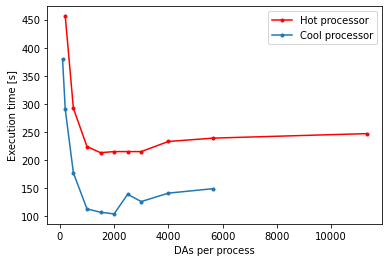

In [24]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

timing = [(5659,149,10),(4000,141,15),(3000,126,19),(2500,139,23),(2000,104,29),(1500,107,38),(1000,113,57),(500,177,114),(200,290,283),(100,380,566)] # (DIV,time)
# after cooling/restart: 2000 92 and 3000,100, which are noticeably shorter...
# below is operating while hot (continuous):
timing_hot = [(11318,247,5),(5659,239,10),(4000,233,15),(3000,215,19),(2500,215,23),(2000,215,29),(1500,213,38),(1000,224,57),(500,292,114),(200,456,283)] # (DIV,time)
x, y, z = zip(*timing)
xh, yh, zh = zip(*timing_hot)
plt.plot(xh,yh,'.-',c='red',label='Hot processor')
plt.plot(x,y,'.-',label='Cool processor')
plt.xlabel('DAs per process')
plt.ylabel('Execution time [s]')
plt.legend()
plt.savefig(DIR_RESULTS+'MultiprocessOptimization.png');
# 200 failed... index 163 for 100... why!? Had to fix update of Part 2 to iloc from loc for case of single-True indb_cut (single True returned a series, not a DF, I think that was the trouble... loc indexing by boolean array can't coerce a DF return... unless ,:]['col'] were used perhaps, but even then just a series would be returned of col values for the row...)

In [21]:
import multiprocess
import CapstoneOverlap
import time
import ipypb # Lightweight progress bar, source copied from GitHub
import geopandas
import pandas as pd
import importlib
importlib.reload(CapstoneOverlap)

def intersectGDFMP(gdf1, key1, gdf2, key2, areas_in=None, verbosity=1, area_epsg=6931, apply_buffer=False, threshold=None, vertex_limit=10000, check_inputs=True, num_process=None, num_block=None):
    '''Multiprocess overlap between geometries in two geodataframes
    
    TODO:
    Verbosity comments in input checks
    Documentation
    Separate multiprocess sections for: input checking, geometry cutting, overlap calculation
    '''

    # Multiprocessing code:
    if __name__ == '__main__':
        
        if verbosity>=1: print('Executing intersectGDFMP')
        begin_time = time.time()
        
        # Input checks
        NCPU = multiprocess.cpu_count()
        N2 = gdf2.shape[0]
        
        if check_inputs:
            if num_process is None:
                num_process = max(1, NCPU-2) # empirical factor for circa 2020 multicore computers, prevents lockup by leaving processes available for the system and other applications
            else:
                try:
                    num_process = int(num_process)
                except (ValueError, TypeError):
                    print(f'Input Error: num_process must be an integer (there are {NCPU} CPUs detected, input was: {num_process})')
                    return None
                if num_process < 0:
                    tmp = num_process
                    num_process = max(1, NCPU-num_process)
                else:
                    num_process = min(NCPU, num_process)
            if verbosity>=1: print(f'  num_process set to {num_process} (of {NCPU})')

            if num_block is None:
                num_block = N2
                if num_process>1:
                    num_block = max(1,num_block//(3*num_process)) # empirical factor based on Canadian census CFSA and DA catographic geometry overlap calculation
            else:
                try:
                    num_block = int(num_block)
                except (ValueError, TypeError):
                    print(f'Input Error: num_block must be an integer (input was: {num_block})')
                    return None
                num_block = max(1,min(num_block,N2))
            if verbosity>=1: print(f'  num_block set to {num_block} (of {N2})')
                
            # Ensure coordinate reference systems match
            if gdf1.crs!=gdf2.crs:
                print(f"Input coordinate reference systems must be the same: gdf1.crs={gdf1.crs}, gdf2.crs={gdf2.crs}")
                return None

            # Ensure geometries are valid
            n_invalid1 = gdf1.shape[0]-sum(gdf1.geometry.is_valid)
            n_invalid2 = gdf2.shape[0]-sum(gdf2.geometry.is_valid)
            if not apply_buffer and (n_invalid1>0 or n_invalid2>0):
                print(f"Input geometries must be valid: {n_invalid1} invalid geometries in gdf1, {n_invalid2} invalid geometries in gdf2")
                return None

            # Ensure areas_in is the proper size
            if not areas_in is None:
                N2 = len(areas_in)
                if N2!=gdf2.shape[0]:
                    print(f"Input areas_in must have length {gdf2.shape[0]}, actual length is {N2}")
                    return None
                N1 = len(areas_in[0])
                irreg = not all([len(a)==N1 for a in areas_in])
                if len(areas_in)!=gdf2.shape[0] or N1!=gdf1.shape[0] or irreg:
                    print(f"Input areas_in must have size [{gdf2.shape[0]}][{gdf1.shape[0]}], actual shape is [{N2}][{N1}]{' with irregular second dimension length' if irreg else ''}")
                    return None

            # Checks performed here, no need to do so in intersectGDF
            check_inputs = False 
        
        NDIV = N2//num_block+(0 if N2%num_block==0 else 1)
        results = [None]*NDIV

        start_time = time.time()
        completed = 0
        with multiprocess.Pool(num_process) as pool:
            print(f'Generating pool, P={num_process}, N={N2}, DIV={num_block}, NDIV={NDIV}')
            ret = [pool.apply_async(CapstoneOverlap.intersectGDF,(gdf1,key1,gdf2.iloc[ind*num_block:((ind+1)*num_block if (ind+1)*num_block<N2 else N2),:],key2,areas_in if areas_in is None else areas_in[ind*num_block:((ind+1)*num_block if (ind+1)*num_block<N2 else N2)],verbosity,area_epsg,apply_buffer,threshold,vertex_limit,check_inputs)) for ind in range(NDIV)]
            print('Processing pool')
            for i in ipypb.track(range(NDIV)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
                while True:
                    indb_finished = [r.ready() for r in ret]
                    indb_empty = [r is None for r in results]
                    indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                    if any(indb_update):
                        ind_update = indb_update.index(True)
                        results[ind_update] = ret[ind_update].get(999) # Set finite timeout so that it returns properly
                        completed += 1
                        if completed%10==0 or completed==1 or completed==(NDIV):
                            print(f'Finished {completed}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
                        break
                    time.sleep(1) # Make the infinite loop run slower; might be improved with explicit async

        wall_time = time.time()-start_time
        processor_time = sum([r[1] for r in results])
        gdf_joined = pd.concat([r[0] for r in results]).sort_values(key2,ignore_index=True)
        print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{NDIV}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, processor:wall ratio {processor_time/wall_time:.3}x')
        print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-begin_time))}')
        return gdf_joined
    return None

In [10]:
import numpy as np

def normalizeRows(areas, aslist=False):
    '''Normalizes each row of the input by its sum (numpy.array)'''
    a = np.array(areas)
    a = a / np.sum(a,axis=1)[:, np.newaxis]
    return a.tolist() if aslist else a

def thresholdAreas(areas, threshold=1e-6, aslist=False):
    '''Zeros out elements of areas that are below the threshold (numpy.array(float))'''
    a = np.array(areas)
    a_ratio = normalizeRows(areas)
    a[a_ratio<threshold] = 0
    return a.tolist() if aslist else a

def normalizeAreas(areas, threshold=1e-6, aslist=False):
    '''Thresholds then normalizes areas (numpy.array(float))'''
    a = thresholdAreas(areas, threshold)
    a = normalizeRows(a)
    return a.tolist() if aslist else a

def maximumAreas(areas, aslist=False):
    '''Zeros out non-maximum elements in each row of areas (numpy.array(int))
    Test with e.g.: (max(np.sum(r,axis=1)), min(np.sum(r,axis=1)), np.sum(r))'''
    a = np.array(areas)
    a_max = np.max(a,axis=1)
    r = (a >= a_max[:,np.newaxis]).astype(int)
    return r.tolist() if aslist else r

Initialization of variables:

In [18]:
DIR_DATA = 'Data/'
DIR_RESULTS = 'Results/Backup2/'
import dill
import gzip
a = loadResults_(DIR_RESULTS+'GDF_FSA-DA_D_M2AREA',[('a','_areas'),],compress=True)[0]

# Select one of the following:
#a = None
#a = a#[aa.tolist() for aa in a]
a = normalizeAreas(a,threshold=1e-6,aslist=True)
#a = maximumAreas(a,aslist=True)

gdf1 = gdf_CA_FSA_Db
key1 = 'CFSAUID'
gdf2 = gdf_CA_DA_Db
key2 = 'DAUID'
areas_in=np.array(a) if not a is None else a
verbosity=1
area_epsg=6931
apply_buffer=False
threshold=None
vertex_limit=10000
check_inputs=True
num_process=10
num_block=2000

Code to execute (reload was used when testing/revising module code):

In [34]:
%%time
import importlib
importlib.reload(CapstoneOverlap)
gdfjmp = intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [02:49<00:06, 5.82s/it]

Finished 1/29, wall time 00:00:15
Finished 10/29, wall time 00:00:52
Finished 20/29, wall time 00:01:49
Finished 29/29, wall time 00:02:49
Pool processing concluded, process count 29/29, wall time 00:02:49, processor time 00:12:39, processor:wall ratio 4.49x
Total time: 00:02:53
Wall time: 2min 53s


## Timing Results

Singular Areas:

    Digital:
        On startup:
        Finished 1/29, wall time 00:00:12
        Finished 10/29, wall time 00:00:20
        Finished 20/29, wall time 00:00:37
        Finished 29/29, wall time 00:00:55
        Pool processing concluded, process count 29/29, wall time 00:00:55, processor time 00:03:55, processor:wall ratio 4.26x
        Total time: 00:00:58
        Wall time: 59.1 s
        
        After heavy computing:
        Finished 1/29, wall time 00:00:15
        Finished 10/29, wall time 00:00:26
        Finished 20/29, wall time 00:00:50
        Finished 29/29, wall time 00:01:36
        Pool processing concluded, process count 29/29, wall time 00:01:36, processor time 00:08:04, processor:wall ratio 5.02x
        Total time: 00:01:40
        Wall time: 1min 40s
        
        After moderate computing:
        Wall time: 1min 21s
        
    Cartographic:
        Finished 1/29, wall time 00:01:21
        Finished 10/29, wall time 00:02:37
        Finished 20/29, wall time 00:04:28
        Finished 29/29, wall time 00:07:45
        Pool processing concluded, process count 29/29, wall time 00:07:45, processor time 00:46:39, processor:wall ratio 6.02x
        Total time: 00:12:00
        Wall time: 12min

Thresholded Areas:

    Digital:
        2nd after startup:
        Finished 1/29, wall time 00:00:11
        Finished 10/29, wall time 00:00:19
        Finished 20/29, wall time 00:00:36
        Finished 29/29, wall time 00:00:56
        Pool processing concluded, process count 29/29, wall time 00:00:56, processor time 00:03:56, processor:wall ratio 4.2x
        Total time: 00:01:00
        Wall time: 1min
        
        After moderate computing:
        Finished 1/29, wall time 00:00:13
        Finished 10/29, wall time 00:00:23
        Finished 20/29, wall time 00:00:45
        Finished 29/29, wall time 00:01:09
        Pool processing concluded, process count 29/29, wall time 00:01:09, processor time 00:04:55, processor:wall ratio 4.26x
        Total time: 00:01:13
        Wall time: 1min 13s
        
    Cartographic:
        Finished 1/29, wall time 00:01:31
        Finished 10/29, wall time 00:02:59
        Finished 20/29, wall time 00:05:07
        Finished 29/29, wall time 00:08:24
        Pool processing concluded, process count 29/29, wall time 00:08:24, processor time 00:51:50, processor:wall ratio 6.16x
        Total time: 00:13:21
        Wall time: 13min 21s
        
Areas Shortcut:

    Digital:
        Third run after startup:
        Finished 1/29, wall time 00:00:15
        Finished 10/29, wall time 00:00:25
        Finished 20/29, wall time 00:00:46
        Finished 29/29, wall time 00:01:31
        Pool processing concluded, process count 29/29, wall time 00:01:31, processor time 00:07:26, processor:wall ratio 4.89x
        Total time: 00:01:35
        Wall time: 1min 35s
        
        After moderate computing:
        Finished 1/29, wall time 00:00:15
        Finished 10/29, wall time 00:00:26
        Finished 20/29, wall time 00:00:50
        Finished 29/29, wall time 00:01:36
        Pool processing concluded, process count 29/29, wall time 00:01:36, processor time 00:08:04, processor:wall ratio 5.02x
        Total time: 00:01:40
        Wall time: 1min 40s
        
    Cartographic:
        Finished 1/29, wall time 00:01:33
        Finished 10/29, wall time 00:02:59
        Finished 20/29, wall time 00:05:31
        Finished 29/29, wall time 00:09:56
        Pool processing concluded, process count 29/29, wall time 00:09:56, processor time 01:01:52, processor:wall ratio 6.22x
        Total time: 00:14:31
        Wall time: 14min 31s
        
All Overlaps:

    Digital:
        Fourth run after startup:
        Finished 1/29, wall time 00:00:16
        Finished 10/29, wall time 00:00:27
        Finished 20/29, wall time 00:00:49
        Finished 29/29, wall time 00:01:45
        Pool processing concluded, process count 29/29, wall time 00:01:45, processor time 00:09:02, processor:wall ratio 5.13x
        Total time: 00:01:50
        Wall time: 1min 50s
        
        Fifth run after startup, after 5 min cooldown
        Finished 1/29, wall time 00:00:16
        Finished 10/29, wall time 00:00:27
        Finished 20/29, wall time 00:00:52
        Finished 29/29, wall time 00:01:50
        Pool processing concluded, process count 29/29, wall time 00:01:50, processor time 00:09:25, processor:wall ratio 5.1x
        Total time: 00:01:54
        Wall time: 1min 54s
        
        Previous best (longer pause before running?)
        Finished 1/29, wall time 00:00:14
        Finished 10/29, wall time 00:00:25
        Finished 20/29, wall time 00:00:45
        Finished 29/29, wall time 00:01:38
        Pool processing concluded, process count 29/29, wall time 00:01:38, processor time 00:08:24, processor:wall ratio 5.13x
        Total time: 00:01:41
        Wall time: 1min 41s
        
        Previous after heavy load (thermal and memory issues?)
        Finished 1/29, wall time 00:00:29
        Finished 10/29, wall time 00:00:50
        Finished 20/29, wall time 00:01:18
        Finished 29/29, wall time 00:02:38
        Pool processing concluded, process count 29/29, wall time 00:02:38, processor time 00:14:36, processor:wall ratio 5.53x
        Total time: 00:02:42
        Wall time: 2min 42s
        
    Cartographic:
        Finished 1/29, wall time 00:00:55
        Finished 10/29, wall time 00:02:17
        Finished 20/29, wall time 00:05:14
        Finished 29/29, wall time 00:10:56
        Pool processing concluded, process count 29/29, wall time 00:10:56, processor time 01:01:27, processor:wall ratio 5.61x
        Total time: 00:14:36
        Wall time: 14min 36s

In [211]:
%%time
import importlib
importlib.reload(CapstoneOverlap)
gdfjmp_alt = CapstoneOverlap.intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [02:15<00:03, 4.67s/it]

Finished 1/29, wall time 00:00:26
Finished 10/29, wall time 00:00:50
Finished 20/29, wall time 00:01:38
Finished 29/29, wall time 00:02:15
Pool processing concluded, process count 29/29, wall time 00:02:16, processor time 00:08:21, processor:wall ratio 3.68x
Total time: 00:02:24
Wall time: 2min 24s


In [212]:
gdfjmp_alt.shape

(56613, 7)

Copied intersectGDFMP to CapstoneOverlap.py in attempt to consolidate all functionality... separate file requirement is only for Jupyter.

In [20]:
%%time
import importlib
importlib.reload(CapstoneOverlap)
gdfjmp = CapstoneOverlap.intersectGDFMP(gdf1, key1, gdf2, key2, areas_in, verbosity, area_epsg, apply_buffer, threshold, vertex_limit, check_inputs, num_process, num_block)

Executing intersectGDFMP
  num_process set to 10 (of 12)
  num_block set to 2000 (of 56590)
Generating pool, P=10, N=56590, DIV=2000, NDIV=29
Processing pool


 [████████████████████████████████████████████████████████████] 29/29 [02:12<00:04, 4.55s/it]

Finished 1/29, wall time 00:00:34
Finished 10/29, wall time 00:00:50
Finished 20/29, wall time 00:01:28
Finished 29/29, wall time 00:02:12
Pool processing concluded, process count 29/29, wall time 00:02:12, processor time 00:10:29, processor:wall ratio 4.74x
Total time: 00:02:18
Wall time: 2min 18s


In [23]:
%%time
import shapely
total = shapely.ops.unary_union(gdfjmp.geometry)

Wall time: 13h 37min 45s


In [ ]:
%%time
total

Try removing interior coordinates with area less than a threshold...

In [81]:
total.type

'MultiPolygon'

In [26]:
len(total)

5

In [ ]:
total[0]

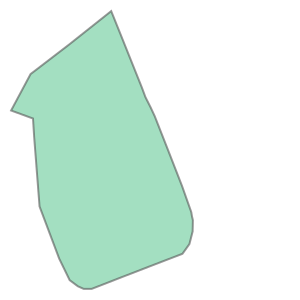

In [28]:
total[1]

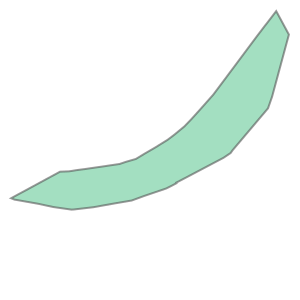

In [177]:
total[2]

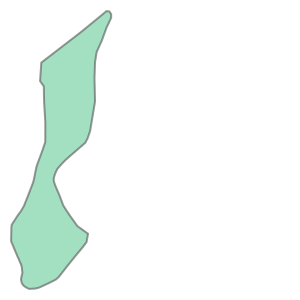

In [178]:
total[3]

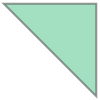

In [179]:
total[4]

In [32]:
cc = [countCoordinates(t) for t in total]
cc

[953099, 49, 66, 178, 4]

In [33]:
total.type

'MultiPolygon'

In [36]:
print(total[4].exterior)

LINEARRING (7224780.29428 933743.2371499999, 7224780.29429 933743.2371499999, 7224780.29429 933743.23714, 7224780.29428 933743.2371499999)


In [37]:
ct = [t.type for t in total]
ct

['Polygon', 'Polygon', 'Polygon', 'Polygon', 'Polygon']

In [39]:
ca = [t.area for t in total]
ca

[13819270164261.314,
 578657432.4811883,
 336766285.4489063,
 1373830187.6205084,
 4.999785107413432e-11]

In [50]:
print(total[3].exterior)

LINEARRING (8393158.33715 1756238.58857, 8393046.088570001 1756638.46857, 8392962.851430001 1756935.00572, 8392865.10857 1757533.68286, 8392893.388569999 1757851.83143, 8392913.98 1758083.48572, 8392928.217150001 1758135.1, 8393011.722859999 1758437.80286, 8393207.20857 1759317.48857, 8393292.73429 1759561.84572, 8393317.171429999 1759891.72572, 8393235.26 1760637.1, 8393222.568569999 1760752.60286, 8393221.802859999 1760759.56572, 8393221.637150001 1760761.07429, 8393194.991429999 1761003.55143, 8393109.46572 1761846.58286, 8392816.23714 1762811.79429, 8392608.534290001 1763239.41715, 8392278.65429 1763972.48857, 8392034.297150001 1764620.03429, 8391735.09715 1765243.36572, 8391735.097139999 1765243.36572, 8391594.454290001 1765536.37429, 8391424.02 1765951.80286, 8391203.482860001 1766489.36572, 8390885.99429 1767225.82572, 8390364.642859999 1768476.06, 8389979.99715 1769398.46286, 8389452.23143 1770629.91429, 8389460.52857 1771314.32857, 8389461.04857 1771357.30857, 8389469.82286000

In [51]:
ci = [len(t.interiors) for t in total]

ci

[136972, 0, 0, 0, 0]

In [54]:
print(shapely.geometry.Polygon(total[2].exterior.coords))

POLYGON ((8683979.74 1496689.96857, 8684966.32 1497232.21143, 8685173.23429 1497343.93715, 8686720.485719999 1498174.86857, 8689713.98 1499801.94, 8691159.388569999 1500583.88286, 8691743.87143 1500903.76857, 8693133.991429999 1500959.05715, 8693355.145719999 1500986.70286, 8694484.617149999 1501168.36572, 8695606.191430001 1501310.53715, 8697422.822860001 1501575.13429, 8698789.245719999 1501768.64572, 8699207.86286 1501835.78, 8701198.26 1502128.02286, 8702193.460000001 1502463.70286, 8703196.557150001 1502755.94572, 8703788.93715 1502925.76, 8705100.07143 1503723.5, 8706656.057150001 1504623.91715, 8707077.95143 1504873.92857, 8707082.57143 1504876.66572, 8707422.20286 1505097.82286, 8708812.322860001 1505958.74857, 8709839.114290001 1506732.79143, 8711489.880000001 1508091.31715, 8712587.76 1509228.68857, 8714088.457149999 1510891.30286, 8715597.05143 1512593.40857, 8716055.15714 1513106.80286, 8717342.59715 1514824.70572, 8717475.477150001 1515002.44, 8718898.58285 1516905.93715, 

In [89]:
shapely.geometry.Polygon(total[2].exterior.coords).area

336766285.4489063

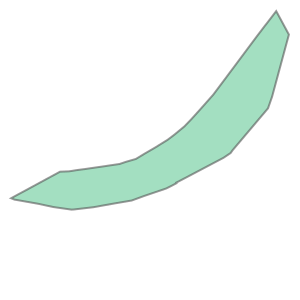

In [95]:
shapely.geometry.Polygon(total[2].exterior.coords[::-1])

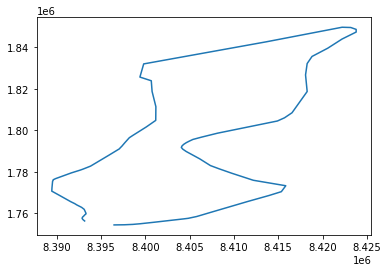

In [168]:
import matplotlib
x,y = total[3].exterior.xy
end = 170
plt.plot(x[0:end],y[0:end])

In [188]:
t3rev = shapely.geometry.polygon.orient(total[3], sign=1.0)

In [189]:
t3rev.type

'Polygon'

In [190]:
t3rev.area

1373830187.6205077

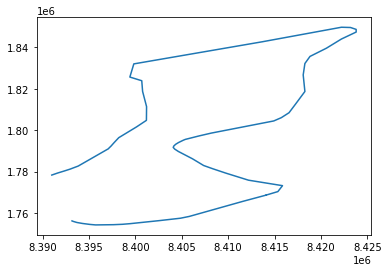

In [173]:
x,y = t3rev.exterior.xy
end = 130
plt.plot(x[0:end],y[0:end])

In [175]:
t3rev.is_valid

True

In [176]:
t3rev.area

1373830187.6205077

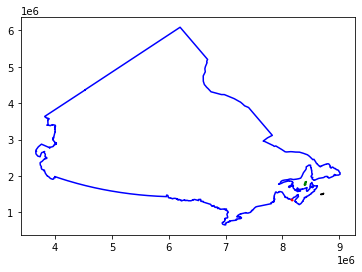

In [191]:
x,y = totalnew[0].exterior.xy
plt.plot(x,y,'blue')
x,y = totalnew[1].exterior.xy
plt.plot(x,y,'red')
x,y = totalnew[2].exterior.xy
plt.plot(x,y,'black')
x,y = totalnew[3].exterior.xy
plt.plot(x,y,'green')

In [144]:
total[3].exterior.xy.type

AttributeError: 'tuple' object has no attribute 'type'

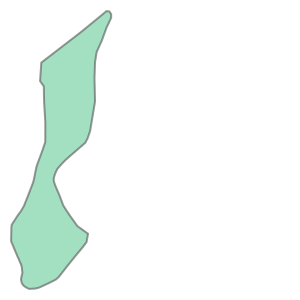

In [136]:
shapely.geometry.Polygon([pt for pt in total[3].exterior.coords[::-1]])

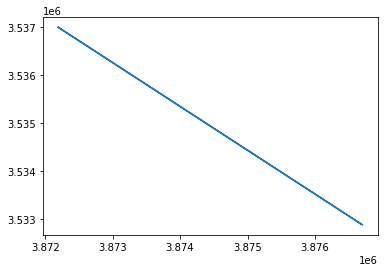

In [117]:
x,y = total[0].interiors[6].xy
plt.plot(x,y)

In [118]:
tiv = [t.is_valid for t in total]
tiv

[True, True, True, True, True]

In [123]:
tmp = [[i for i in t.coords] for t in total[0].interiors if t.area>0]
tmp

[]

In [ ]:
total0 = shapely.geometry.Polygon(total[0].exterior,tmp)
total0

In [ ]:
totalnew = shapely.geometry.MultiPolygon([total0,total[1],total[2],total[3]])
totalnew

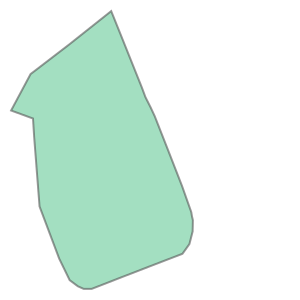

In [200]:
totalnew[1]

In [130]:
t2 = total[2]
t2o = shapely.geometry.polygon.orient(t2, sign=1.0)
t2o.interior.area

AttributeError: 'Polygon' object has no attribute 'interior'

In [ ]:
total[2].buffer(0)

In [58]:
c1a = [total[0].interiors[i].area for i in range(len(total[0].interiors))]


NameError: name 'plt' is not defined

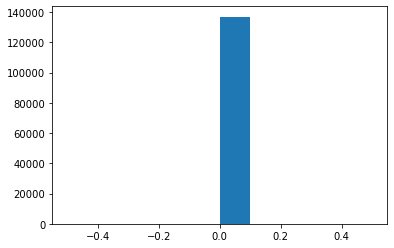

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(c1a);

In [61]:
max(abs(np.array(c1a)))

0.0

In [63]:
t = total
t[0].interiors = []
t[0]

AttributeError: can't set attribute

In [67]:
t0 = shapely.geometry.Polygon(list(total[0].exterior.coords))

In [ ]:
display(t0)

In [96]:
%%time
tb = total.buffer(0)

Wall time: 15min 24s


In [ ]:
tb

In [207]:
%%time
gdf1.total_bounds

Wall time: 144 ms


array([3658201.494285,  658872.974285, 9019156.614285, 6083004.85143 ])

In [204]:
def getGDFBounds(gdf):
    '''Calculates the bounds of all geometries in gdf'''
    tmp = gdf.geometry.unary_union.envelope.boundary.coords.xy
    bounds = [[min(tmp[1]),min(tmp[0])],[max(tmp[1]),max(tmp[0])]]
    return bounds

In [206]:
%%time
getGDFBounds(gdf1)

Wall time: 25.5 s


[[658872.974284999, 3658201.494285], [6083004.85143, 9019156.614285]]

In [208]:
def getGDFBounds(gdf):
    '''Calculates the bounds of all geometries in gdf'''
    tmp = gdf.geometry.total_bounds
    return [[tmp[1],tmp[0]],[tmp[3],tmp[2]]]

In [209]:
%%time
getGDFBounds(gdf1)

Wall time: 91.8 ms


[[658872.974284999, 3658201.494285], [6083004.85143, 9019156.614285]]